In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':"13xmiSh8AgQjj6BJ7Dxu_byo59bnlUT8h"})   # replace the id with id of file you want to access
downloaded.GetContentFile('data.csv')        # replace the file name with your file

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
import warnings; warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
dataset = pd.read_csv('data.csv',encoding="ISO-8859-1") #dataset incorporation
dataset.drop(['stn_code','agency','sampling_date','location_monitoring_station'], axis=1,inplace=True)

In [0]:
# Removing outliers ( )
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)  #it is middle number between smallest value and median
    q3 = df_in[col_name].quantile(0.75) #it is middle number between largest value and median
    iqr = q3-q1    #Interquartile range
    low_range  = q1-1.5*iqr  #any number suspected lower than this value is suspected outlier
    high_range = q3+1.5*iqr  #any number suspected higher than this value is suspected outlier
    df_out = df_in.loc[(df_in[col_name] > low_range) & (df_in[col_name] < high_range)]   # limiting the dataset values to just the range where outliers does not exists

# calling function to remove outlier values from the pollutant columns of the dataset
remove_outlier(dataset,'so2')
remove_outlier(dataset,'no2')
remove_outlier(dataset,'rspm')
remove_outlier(dataset,'spm')

In [0]:
statewise = dataset.groupby('state')      #grouping dataset by state

# filling the nan values with the mean of that column 
def calc_mean(series):
    return series.fillna(series.mean()) 

dataset['rspm'] = statewise['rspm'].transform(calc_mean) #transforming null values in rspm column
dataset['so2'] = statewise['so2'].transform(calc_mean) #transforming null values in so2 column
dataset['no2'] = statewise['no2'].transform(calc_mean) #transforming null values in no2 column
dataset['spm'] = statewise['spm'].transform(calc_mean)#transforming null values in spm column
dataset['pm2_5'] = statewise['pm2_5'].transform(calc_mean) #transforming null values in pm25 column

In [0]:
# Derivation for Individual Pollutant Index and AQI STARTS HERE

# EPA METHOD FORMULA
#  AQI_{P} = AQI_{min} +  ({PM_{Obs}-PM_{Min}}/{(PM_{Max}-PM_{Min})})* {AQI_{Max}-AQI_{Min}}

# calculating AQI index of SO2 pollutant by EPA method formula given above
#  SO2 is scaled between 0-1600
def calculate_si(so2):
    si=0
    if (so2<=40):
     si = so2 * (50/40)
    elif (so2>40 and so2<=80):
     si = 50 + (so2-40) * (50/(80-40))
    elif (so2>80 and so2<=380):
     si = 100 + (so2-80) * (100/(380-80))
    elif (so2>380 and so2<=800):
     si = 200 + (so2-380) * (100/(800-380))
    elif (so2>800 and so2<=1600):
     si = 300 + (so2-800) * (100/(1600-800))
    elif (so2>1600):
     si = 400 + (so2-1600) * (100/800)
    return si

# calling the function to calulate so2 pollutant index
dataset['si'] = dataset['so2'].apply(calculate_si)
df_si = dataset[['so2','si']]
df_si.head()

,so2,si
0,4.8,6.000
1,3.1,3.875
2,6.2,7.750
3,6.3,7.875
4,4.7,5.875


In [0]:
#Function to calculate no2 individual pollutant index(ni)

# EPA METHOD FORMULA
#  AQI_{PM} = AQI_{min} +  ({PM_{Obs}-PM_{Min}}/{(PM_{Max}-PM_{Min})})* {AQI_{Max}-AQI_{Min}}

# calculating AQI index of NO2 pollutant by EPA method formula given above
#  NO2 is scaled between 0-400
def calculate_ni(no2):
    ni = 0
    if(no2<=40):
     ni = no2*50/40
    elif(no2>40 and no2<=80):
     ni = 50 + (no2-40)*(50/(80-40))
    elif(no2>80 and no2<=180):
     ni = 100 + (no2-80)*(100/(180-80))
    elif(no2>180 and no2<=280):
     ni = 200 + (no2-180)*(100/(280-180))
    elif(no2>280 and no2<=400):
     ni = 300 + (no2-280)*(100/(400-280))
    else:
     ni = 400 + (no2-400)*(100/120)
    return ni

# calling the function to calulate so2 pollutant index
dataset['ni'] = dataset['no2'].apply(calculate_ni)
df_ni = dataset[['no2','ni']]
df_ni.head()

,no2,ni
0,17.4,21.750
1,7.0,8.750
2,28.5,35.625
3,14.7,18.375
4,7.5,9.375


In [0]:
#Function to calculate rspm individual pollutant index(rpi)

# EPA METHOD FORMULA
#  AQI_{PM} = AQI_{min} +  ({PM_{Obs}-PM_{Min}}/{(PM_{Max}-PM_{Min})})* {AQI_{Max}-AQI_{Min}}

# calculating AQI index of RSPM pollutant by EPA method formula given above
#  RSPM is scaled between 0-400
def calculate_(rspm):
    rpi=0
    if(rpi<=30):
     rpi = rpi*50/30
    elif(rpi>30 and rpi<=60):
     rpi = 50+(rpi-30)*50/(60-30)
    elif(rpi>60 and rpi<=90):
     rpi = 100+(rpi-60)*100/(90-60)
    elif(rpi>90 and rpi<=120):
     rpi = 200+(rpi-90)*100/(120-90)
    elif(rpi>120 and rpi<=250):
     rpi = 300+(rpi-120)*(100/(250-120))
    else:
     rpi = 400+(rpi-250)*(100/130)
    return rpi

# calling the function to calulate RSPM pollutant index
dataset['rpi']=dataset['rspm'].apply(calculate_si)
df_rpi = dataset[['rspm','rpi']]
df_rpi.head()


,rspm,rpi
0,78.182824,97.72853
1,78.182824,97.72853
2,78.182824,97.72853
3,78.182824,97.72853
4,78.182824,97.72853


In [0]:
#Function to calculate spm individual pollutant index(spi)

# EPA METHOD FORMULA
#  AQI_{PM} = AQI_{min} +  ({PM_{Obs}-PM_{Min}}/{(PM_{Max}-PM_{Min})})* {AQI_{Max}-AQI_{Min}}

# calculating AQI index of SPM pollutant by EPA method formula given above
#  SPM is scaled between 0-400
def calculate_spi(spm):
    spi=0
    if(spm<=50):
     spi = spm*50/50
    elif(spm>50 and spm<=100):
     spi = 50 + (spm-50)*(50/(100-50))
    elif(spm>100 and spm<=250):
     spi = 100 + (spm-100)*(100/(250-100))
    elif(spm>250 and spm<=350):
     spi=200 + (spm-250)*(100/(350-250))
    elif(spm>350 and spm<=430):
     spi=300 + (spm-350)*(100/(430-350))
    else:
     spi=400+(spm-430)*(100/430)
    return spi

# calling the function to calulate SPM pollutant index
dataset['spi'] = dataset['spm'].apply(calculate_spi)
df_spm = dataset[['spm','spi']]
df_spm.head()

,spm,spi
0,200.260378,166.840252
1,200.260378,166.840252
2,200.260378,166.840252
3,200.260378,166.840252
4,200.260378,166.840252


In [0]:
#function to calculate the air quality index (AQI) of every data value its is calculated as per indian govt standards

# AQI = MAX ( AQI_{SO2}, AQI_{NO2}, AQI_{RSPM}, AQI_{SPM})
def calculate_aqi(si,ni,spi,rpi):
    aqi=0
    if(si>ni and si>spi and si>rpi):
     aqi=si
    if(spi>si and spi>ni and spi>rpi):
     aqi=spi
    if(ni>si and ni>spi and ni>rpi):
     aqi=ni
    if(rpi>si and rpi>ni and rpi>spi):
     aqi=rpi
    return aqi

# calling the function to calulate AQI 
dataset['AQI'] = dataset.apply(lambda x:calculate_aqi(x['si'],x['ni'],x['spi'],x['rpi']),axis=1)
df= dataset[['state','si','ni','rpi','spi','AQI']]
df.head()

,state,si,ni,rpi,spi,AQI
0,Andhra Pradesh,6.000,21.750,97.72853,166.840252,166.840252
1,Andhra Pradesh,3.875,8.750,97.72853,166.840252,166.840252
2,Andhra Pradesh,7.750,35.625,97.72853,166.840252,166.840252
3,Andhra Pradesh,7.875,18.375,97.72853,166.840252,166.840252
4,Andhra Pradesh,5.875,9.375,97.72853,166.840252,166.840252


In [0]:
dataset.fillna(0.0,inplace=True)

dataset['date'] = pd.to_datetime(dataset['date'],format='%Y-%m-%d') # transforming the date column into '%Y-%m-%d' formate 
dataset['year'] = dataset['date'].dt.year                           # extracting year from the date column
dataset['year'] = dataset['year'].fillna(0.0).astype(int)           # filling nan values as 0
dataset = dataset[(dataset['year']>0)]                              # extracting only non null values

In [0]:
dataset.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date,si,ni,rpi,spi,AQI
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,78.182824,200.260378,0.0,1990-02-01,6.000,21.750,97.72853,166.840252,166.840252
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,78.182824,200.260378,0.0,1990-02-01,3.875,8.750,97.72853,166.840252,166.840252
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,78.182824,200.260378,0.0,1990-02-01,7.750,35.625,97.72853,166.840252,166.840252
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,78.182824,200.260378,0.0,1990-03-01,7.875,18.375,97.72853,166.840252,166.840252
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,78.182824,200.260378,0.0,1990-03-01,5.875,9.375,97.72853,166.840252,166.840252


In [0]:
data1 = dataset.copy()
filter = data1["state"]=="Delhi"
data1.where(filter, inplace = True) 
data1 = data1.dropna()

In [0]:
data2 = dataset.copy()
filter = data2["state"]=="Maharashtra"
data2.where(filter, inplace = True) 
data2 = data2.dropna()

data3 = dataset.copy()
filter = data3["state"]=="Gujarat"
data3.where(filter, inplace = True) 
data3 = data3.dropna()

In [0]:
def gradient_boosting_classifier(classifier, X, y, count):

    # Gradient Boosting Regression
    #GB = GradientBoostingRegressor()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)  # dividing int training and test set

    # One Hot Encoding
    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)

    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    predictions1 = classifier.predict(X)

    print(X_test.shape,X_train.shape,y_test.shape, predictions.shape,y_train.shape)
    print('r2_Square:%.2f '% r2_score(y_test, predictions))
    print('MSE:%.2f '% np.sqrt(mean_squared_error(y_test, predictions)))
    print("KfoldCrossVal mean score using Linear regression is %s" %cross_val_score(classifier,X_train,y_train,cv=10).mean())

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    Kfold = cross_val_score(classifier,X_train,y_train,cv=10).mean()

    #plt.figure(figsize=(10,10))
    #plt.scatter(y_test,predictions, color = "red", alpha=0.1)
    #plt.xlabel('Predictions')

    #plt.ylabel('AQI')
    #plt.title("Gradient Boosting Regression")
    #plt.show()

    if(count == 1):
      data1['predictedGb'] = predictions1
      df = data1[['AQI','year','state']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False)
      df1 = data1[['predictedGb','year','state']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False)
      #f,ax=plt.subplots(figsize=(15,10))
      #sns.pointplot(x='year', y='AQI', data=df, color='r', label="Actual")
      #sns.pointplot(x='year', y='predictedGb', data=df1, color='g', label="predicted")
    elif(count==2):
      data2['predictedGb'] = predictions1
      df = data2[['AQI','year','state']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False)
      df1 = data2[['predictedGb','year','state']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False)
      #f,ax=plt.subplots(figsize=(15,10))
      #sns.pointplot(x='year', y='AQI', data=df, color='r', label="Actual")
      #sns.pointplot(x='year', y='predictedGb', data=df1, color='g', label="predicted")
    elif(count==3):
      data3['predictedGb'] = predictions1
      df = data3[['AQI','year','state']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False)
      df1 = data3[['predictedGb','year','state']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False)
      #f,ax=plt.subplots(figsize=(15,10))
      #sns.pointplot(x='year', y='AQI', data=df, color='r', label="Actual")
      #sns.pointplot(x='year', y='predictedGb', data=df1, color='g', label="predicted")

    return rmse
   

In [0]:
from sklearn.ensemble import GradientBoostingRegressor
GB = GradientBoostingRegressor()

X_1 = data1[['so2','no2','rspm','spm']]   # independent variables - polluntants
y_1 = data1['AQI'] # target variable - AQI
rmse_1_gbr = gradient_boosting_classifier(GB, X_1, y_1,1)

X_2 = data2[['so2','no2','rspm','spm']]   # independent variables - polluntants
y_2 = data2['AQI'] # target variable - AQI
rmse_2_gbr = gradient_boosting_classifier(GB, X_2, y_2,2)

X_3 = data3[['so2','no2','rspm','spm']]   # independent variables - polluntants
y_3 = data3['AQI'] # target variable - AQI
rmse_3_gbr = gradient_boosting_classifier(GB, X_3, y_3,3)

(1711, 4) (6840, 4) (1711,) (1711,) (6840,)
r2_Square:1.00 
MSE:2.54 
KfoldCrossVal mean score using Linear regression is 0.999766410448952
(12077, 4) (48307, 4) (12077,) (12077,) (48307,)
r2_Square:1.00 
MSE:1.58 
KfoldCrossVal mean score using Linear regression is 0.9981452674111715
(4256, 4) (17023, 4) (4256,) (4256,) (17023,)
r2_Square:1.00 
MSE:1.41 
KfoldCrossVal mean score using Linear regression is 0.998929301149752


In [0]:
from sklearn.tree import DecisionTreeRegressor
DT = DecisionTreeRegressor()

X_1 = data1[['so2','no2','rspm','spm']]   # independent variables - polluntants
y_1 = data1['AQI'] # target variable - AQI
rmse_1_dt = gradient_boosting_classifier(DT, X_1, y_1,1)

X_2 = data2[['so2','no2','rspm','spm']]   # independent variables - polluntants
y_2 = data2['AQI'] # target variable - AQI
rmse_2_dt = gradient_boosting_classifier(DT, X_2, y_2,2)

X_3 = data3[['so2','no2','rspm','spm']]   # independent variables - polluntants
y_3 = data3['AQI'] # target variable - AQI
rmse_3_dt = gradient_boosting_classifier(DT, X_3, y_3,3)

(1711, 4) (6840, 4) (1711,) (1711,) (6840,)
r2_Square:1.00 
MSE:2.66 
KfoldCrossVal mean score using Linear regression is 0.9998401437433608
(12077, 4) (48307, 4) (12077,) (12077,) (48307,)
r2_Square:1.00 
MSE:2.60 
KfoldCrossVal mean score using Linear regression is 0.9985168568910983
(4256, 4) (17023, 4) (4256,) (4256,) (17023,)
r2_Square:1.00 
MSE:0.77 
KfoldCrossVal mean score using Linear regression is 0.9994785300181368


In [0]:
from sklearn.ensemble import RandomForestRegressor
DT = RandomForestRegressor()

X_1 = data1[['so2','no2','rspm','spm']]   # independent variables - polluntants
y_1 = data1['AQI'] # target variable - AQI
rmse_1_rf = gradient_boosting_classifier(DT, X_1, y_1,1)

X_2 = data2[['so2','no2','rspm','spm']]   # independent variables - polluntants
y_2 = data2['AQI'] # target variable - AQI
rmse_2_rf = gradient_boosting_classifier(DT, X_2, y_2,2)

X_3 = data3[['so2','no2','rspm','spm']]   # independent variables - polluntants
y_3 = data3['AQI'] # target variable - AQI
rmse_3_rf = gradient_boosting_classifier(DT, X_3, y_3,3)

(1711, 4) (6840, 4) (1711,) (1711,) (6840,)
r2_Square:1.00 
MSE:0.26 
KfoldCrossVal mean score using Linear regression is 0.9997675908808361
(12077, 4) (48307, 4) (12077,) (12077,) (48307,)
r2_Square:1.00 
MSE:1.36 
KfoldCrossVal mean score using Linear regression is 0.9987434607176866
(4256, 4) (17023, 4) (4256,) (4256,) (17023,)
r2_Square:1.00 
MSE:1.76 
KfoldCrossVal mean score using Linear regression is 0.999181286406556


In [0]:
from sklearn.linear_model import LinearRegression

DT = LinearRegression()

X_1 = data1[['so2','no2','rspm','spm']]   # independent variables - polluntants
y_1 = data1['AQI'] # target variable - AQI
rmse_1_lr = gradient_boosting_classifier(DT, X_1, y_1,1)

X_2 = data2[['so2','no2','rspm','spm']]   # independent variables - polluntants
y_2 = data2['AQI'] # target variable - AQI
rmse_2_lr = gradient_boosting_classifier(DT, X_2, y_2,2)

X_3 = data3[['so2','no2','rspm','spm']]   # independent variables - polluntants
y_3 = data3['AQI'] # target variable - AQI
rmse_3_lr = gradient_boosting_classifier(DT, X_3, y_3,3)

(1711, 4) (6840, 4) (1711,) (1711,) (6840,)
r2_Square:0.83 
MSE:38.55 
KfoldCrossVal mean score using Linear regression is 0.83716226641506
(12077, 4) (48307, 4) (12077,) (12077,) (48307,)
r2_Square:0.93 
MSE:15.38 
KfoldCrossVal mean score using Linear regression is 0.9323526188078748
(4256, 4) (17023, 4) (4256,) (4256,) (17023,)
r2_Square:0.92 
MSE:17.54 
KfoldCrossVal mean score using Linear regression is 0.9185232930280766


[38.547426932091554, 2.660517460848958, 0.26439106226680786, 2.5428164102831383]


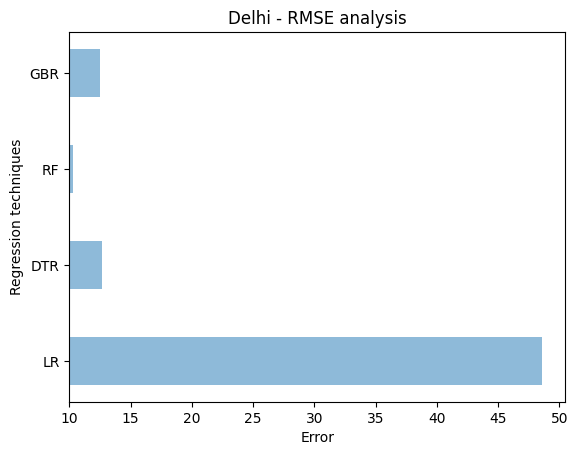

In [0]:
import matplotlib.pyplot as plt; plt.rcdefaults()
objects = ('LR', 'DTR', 'RF', 'GBR')   # plotting rmse of all the regression techniques
y_pos = np.arange(len(objects))
performance1 = [rmse_1_lr, rmse_1_dt, rmse_1_rf, rmse_1_gbr]  # rmse performance
performance2 = [rmse_2_lr, rmse_2_dt, rmse_2_rf, rmse_2_gbr]  # rmse performance
performance3 = [rmse_3_lr, rmse_3_dt, rmse_3_rf, rmse_3_gbr]  # rmse performance

# printing the bar chart showing RMSE of all the 4 regression techniques mentioned above
print(performance1)
width=0.5
plt.barh(y_pos, performance1, width, height, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Error')
plt.ylabel('Regression techniques')
plt.title('Delhi - RMSE analysis')
plt.show()

[15.384075923673938, 2.602960803654794, 1.3608920960630642, 1.575954378255974]


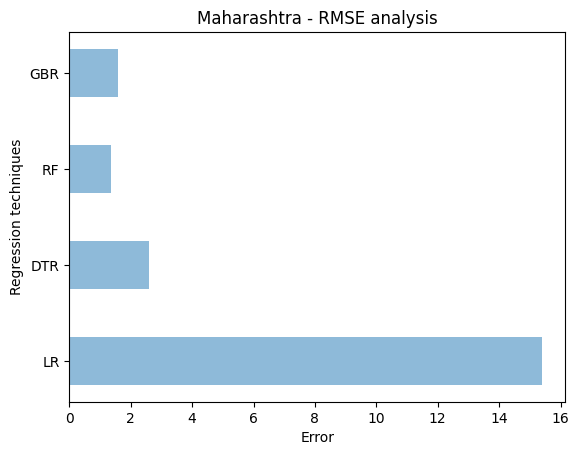

In [0]:
print(performance2)
width=0.5
plt.barh(y_pos, performance2, width, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Error')
plt.ylabel('Regression techniques')
plt.title('Maharashtra - RMSE analysis')
plt.show()

[38.547426932091554, 2.660517460848958, 0.26439106226680786, 2.5428164102831383]


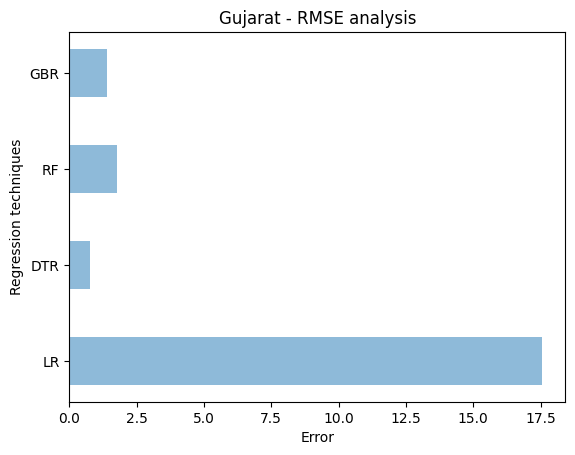

In [0]:
print(performance1)
plt.barh(y_pos, performance3, width, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Error')
plt.ylabel('Regression techniques')
plt.title('Gujarat - RMSE analysis')
plt.show()